# Test dsa <-> PF muon cross references

The goal is to be able to access the DSA muons matched to PF muons (and vice versa). 

Running on Coffea2025.5.0.rc2 build (release candidate).

This notebook shows how to access the matched muons and how to check if the selections are applied. 

*NOTE:* Right now, the code only works if you comment out [these lines](https://github.com/scikit-hep/coffea/blob/539c4b58961b7bae86038caf67f1c7db83dded3a/coffea/nanoevents/transforms.py#L129-L130) in your local coffea install (found at /usr/local/lib/python3.12/site-packages/coffea/nanoevents/transforms.py). In the future, we'll use [our own fork of coffea](https://github.com/cms-sidm/coffea) with these changes applied. In the farther future, we'll update these variables in the next round of LLPNanoAOD production to be ints rather than floats.


## Test with NanoEventsFactory

First we'll open a single file and investigate it with NanoEventsFactory using the new schema

In [1]:
# python
import awkward as ak
#import numpy as np
import sys
import os
import importlib
# columnar analysis
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor
# local
sidm_path = str(os.getcwd()).split("/sidm")[0]
if sidm_path not in sys.path: sys.path.insert(1, sidm_path)
from sidm.tools import llpnanoaodschema
from sidm.tools import utilities
# always reload local modules to pick up changes during development
importlib.reload(llpnanoaodschema)
importlib.reload(utilities)

/tmp/ipykernel_3565/2607151500.py:8: DeprecationWarning: NanoEventsFactory.from_root() behavior has changed.
    The default behavior is that now it reads the input root file using
    the newly developed virtual arrays backend of awkward instead of dask.
    The backend choice is controlled by the `mode` argument of the method
    which can be set to "eager", "virtual", or "dask".
    The new default is "virtual" while the `delayed` argument has been removed.
    The old `delayed=True` is now equivalent to `mode="dask"`.
    The old `delayed=False` is now equivalent to `mode="eager"`.
    
  from coffea.nanoevents import NanoEventsFactory, NanoAODSchema


<module 'sidm.tools.utilities' from '/home/cms-jovyan/SIDM_forks_2025/dsaMatching_clean/SIDM/sidm/tools/utilities.py'>

In [2]:
samples = [
    '2Mu2E_500GeV_5p0GeV_8p0mm',
]
fileset = utilities.make_fileset(samples, "llpNanoAOD_v2", max_files=1, location_cfg="signal_2mu2e_v10.yaml")
fname = fileset[samples[0]]["files"][0]

In [3]:
factory_llp = NanoEventsFactory.from_root(
    {fname: "Events"},
    schemaclass=llpnanoaodschema.LLPNanoAODSchema,
)

/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(


In [4]:
events_llp = factory_llp.events()

Check if matched_muons is included in the DSAMuon collection and matched_dsa_muons is included in the Muon collection

In [5]:
pf = events_llp.Muon
dsa = events_llp.DSAMuon
jet = events_llp.Jet
all_attrs = dir(dsa)
print("Matched variables for DSAMuons: ",[attr for attr in all_attrs if attr.startswith('mat')])

all_attrs = dir(pf)
print("Matched variables for Muons: ",[attr for attr in all_attrs if attr.startswith('mat')])



Matched variables for DSAMuons:  ['matched_muons']
Matched variables for Muons:  ['matched_dsa_muons']


Materialize some of the arrays so we can inspect their contents. These are the commands (specifically materializing the dsa.muonIdxG array) that will throw a RunTimeError if the idx variables are floats and you didn't comment out the lines mentioned above in your coffea install.


In [6]:
ak.materialize(dsa.muonMatch1)
ak.materialize(dsa.muonMatch1idx)
ak.materialize(dsa.pt)
ak.materialize(pf.pt)
ak.materialize(dsa.muonMatch4idx)
ak.materialize(dsa.muonIdxG)
ak.materialize(dsa.muonMatch1idxG)

<Array [[4607182418800017408, 0], ..., [...]] type='4364 * var * int64[para...'>

Inspect the events: In event 1, we have three dsa muons and 2 pf muons. The first dsa muon matches the 2nd pf muon and vice versa:

In [7]:
print("DSA pt in events 0-2:", dsa.pt[0:3].to_list())
print("PF pt in events 0-2:", pf[0:3].pt.to_list())
print("ID of PF muons matched to DSA muons in events 0-2:",dsa.muonIdxG[0:3].to_list()) #global index (for the first 5 matches)
print("pt of PF muons matched to DSA muons in event 0:",dsa.matched_muons.pt[0].to_list())

DSA pt in events 0-2: [[90.20301055908203, 169.33285522460938], [5.917826175689697, 321.9776916503906, 1.6178698539733887], [161.76913452148438, 24.506929397583008]]
PF pt in events 0-2: [[717.1842651367188, 135.23300170898438], [212.15811157226562, 5.346219539642334], [197.0467071533203, 21.183835983276367]]
ID of PF muons matched to DSA muons in events 0-2: [[[1, 0, -1, -1, -1], [0, 1, -1, -1, -1]], [[3, 2, -1, -1, -1], [2, 3, -1, -1, -1], [3, 2, -1, -1, -1]], [[4, 5, -1, -1, -1], [5, 4, -1, -1, -1]]]
pt of PF muons matched to DSA muons in event 0: [[135.23300170898438, 717.1842651367188, None, None, None], [717.1842651367188, 135.23300170898438, None, None, None]]


Great, it appears matched_muons allows me to access the muons that correspond to `muonMatchNidx` branches. Next check that we can access the **number** of segment matches for that pair:

In [8]:
all_attrs_matched = dir(dsa.matched_muons)
print([attr for attr in all_attrs_matched if attr.startswith('num')])
print("Number of segment matches for PF muons matched to DSA muons in event 0:",dsa.matched_muons.numMatch[0].to_list())

['numMatch', 'numba_type']
Number of segment matches for PF muons matched to DSA muons in event 0: [[2.0, 0.0, None, None, None], [3.0, 0.0, None, None, None]]


## Test in the processor

Make sure we can access the variables from within the processor and can apply selections as expected.

The variables after selection are **matched_good_dsa** etc

Note that we won't be able to access the matched_muons arrays if accessing a dsa muon from within a lepton jet (at least not for now) or vice versa

In [9]:
# python
import sys, os
import importlib
# columnar analysis
from coffea.nanoevents import NanoAODSchema
from coffea import processor
# local
sidm_path = str(os.getcwd()).split("/sidm")[0]
if sidm_path not in sys.path: sys.path.insert(1, sidm_path)
from sidm.tools import sidm_processor, utilities
from sidm.tools import llpnanoaodschema
# always reload local modules to pick up changes during development
importlib.reload(sidm_processor)
importlib.reload(utilities)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()

In [10]:
samples = [
    '2Mu2E_500GeV_5p0GeV_8p0mm',
]
fileset = utilities.make_fileset(samples, "llpNanoAOD_v2", max_files=1, location_cfg="signal_2mu2e_v10.yaml")

Run the processor! Note that there is one selection that doesn't work right now: we can't apply the dR(dsa, pf) > 0.2 cut to the matched_dsa_muons nested within the pf muons (but I don't think we want to anyway, since that's circular. We'd need to redefine it to use the matched collections instead)

In [11]:
runner = processor.Runner(
    executor=processor.IterativeExecutor(),
    schema=llpnanoaodschema.LLPNanoAODSchema,
    maxchunks=1,
    skipbadfiles=True,
)

channels = [
    "baseNoLjNoLjsource", #No cuts on the pf or dsa muons
    "base" #Includes pf and dsa IDs, which should be applied to the nested collections as well
]
p = sidm_processor.SidmProcessor(
    channels,
    ["base"],
    verbose=True,
    unweighted_hist=True
)

output = runner.run(fileset, treename='Events', processor_instance=p)
out = output["out"]

Output()

Output()

/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing 
cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(

/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing 
cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(

/usr/local/lib/python3.12/site-packages/awkward/_nplikes/array_module.py:292: RuntimeWarning: invalid value 
encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))

Applying genMus status 1

Applying genEs status 1

Warning: Did not find cuts for muons in the config. No cuts will be applied to the nested objects

Warning: Did not find cuts for dsaMuons in the config. No cuts will be applied to the nested objects

#--------------------------------------------------------------------------
#                         FastJet release 3.4.3
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


Applying cut: pass triggers

Applying cut: PV filter

Applying genMus status 1

Applying genEs status 1

Applying electrons pT > 10 GeV

Applying electrons |eta| < 2.4

Applying electrons MVANonIsoWPL

Applying muons looseID

Applying muons pT > 5 GeV

Applying muons |eta| < 2.4

Applying photons pT > 20 GeV

Applying photons |eta| < 2.5

Applying photons Custom Cutbased

Applying photons pixelSeed

Applying photons Photon DR Veto 0p025

Applying dsaMuons pT > 10 GeV

Applying dsaMuons |eta| < 2.4

Applying dsaMuons displaced ID

Applying cuts to the nested muons collection

Applying cuts to the nested dsaMuons collection

Applying ljs pT > 30 GeV

Applying ljs |eta| < 2.4

Applying ljs mu_charge == 0

Applying cut: pass triggers

Applying cut: PV filter

Applying cut: >=2 LJs

Signal not in xs cfg, assuming 1fb


Now test it worked. First plot the number of muons and dsa muons

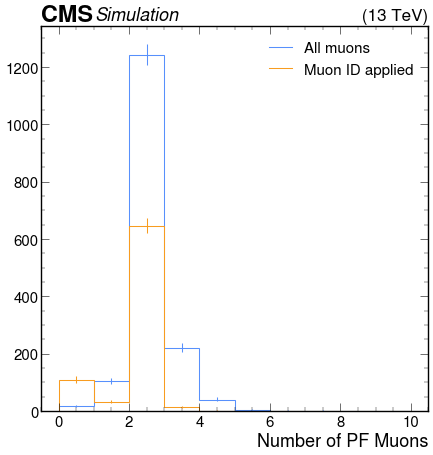

In [12]:
utilities.plot([
    out[samples[0]]["hists"]["muon_n"][channels[0], :],
    out[samples[0]]["hists"]["muon_n"][channels[1], :],
])
plt.legend(["All muons", "Muon ID applied"])

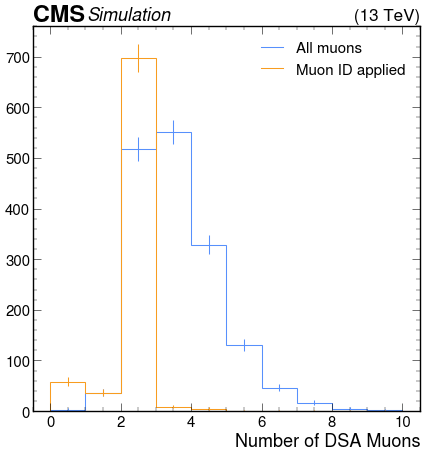

In [13]:
utilities.plot([
    out[samples[0]]["hists"]["dsaMuon_n"][channels[0], :],
    out[samples[0]]["hists"]["dsaMuon_n"][channels[1], :],
])
plt.legend(["All muons", "Muon ID applied"])

So the base selections are still working as expected. What about for the nested collections?

Plot the number of matching segments for dsa-pf matches and vice versa

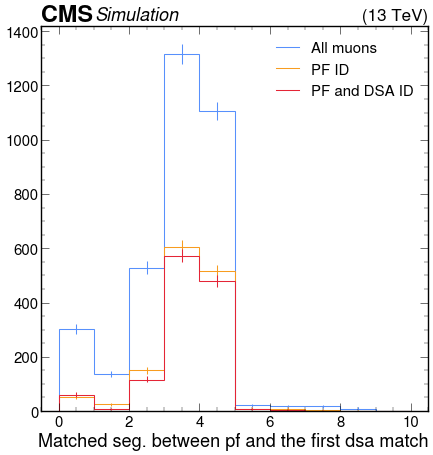

In [14]:
utilities.plot([
    out[samples[0]]["hists"]["muon_numOverlapSegments_matchedDSAMuons"][channels[0], :],
    out[samples[0]]["hists"]["muon_numOverlapSegments_matchedDSAMuons"][channels[1], :], #No selections applied to DSA muons in matching
    out[samples[0]]["hists"]["muon_numOverlapSegments_goodMatchedDSAMuons"][channels[1], :], #Normal selections applied to DSA muons in matching

])
plt.xlabel("Matched seg. between pf and the first dsa match" )
plt.legend(["All muons", "PF ID","PF and DSA ID"])

The first bin in this plot seems to imply that we aren't handling the no match case correctly. If there is *not* a matched dsa muon passing the cuts, it seems to fall in bin 0 here (instead of being None/not showing up in the histogram at all, which I think would be the preferred behavior)

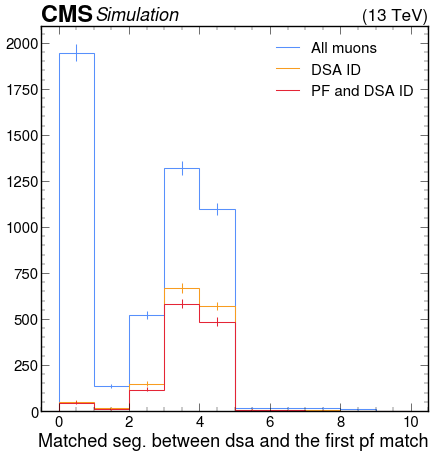

In [15]:
utilities.plot([
    out[samples[0]]["hists"]["dsaMuon_numOverlapSegments_matchedMuons"][channels[0], :],
    out[samples[0]]["hists"]["dsaMuon_numOverlapSegments_matchedMuons"][channels[1], :], # No selections applied to dsa muons in matching
    out[samples[0]]["hists"]["dsaMuon_numOverlapSegments_goodMatchedMuons"][channels[1], :], # Normal selections applied to pf muons in matching

])
#plt.yscale("log")
plt.xlabel("Matched seg. between dsa and the first pf match" )
plt.legend(["All muons", "DSA ID","PF and DSA ID"])

This will need more sanity checks to see if it works as expected, but I think the results make sense.

Side note... if you leave the "dR(dsa, pf) > 0.2" selection applied to dsa muons, then this plot looks dramatically different. It kills all dsa muons in the red curve only. Which confuses me, because the dsa muon cuts should be applied the same to both orange and red... might need to investigate more. But that cut needs to be redefined anyway.